In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import solver.geometry as geometry
import solver.time as time

import warnings
warnings.filterwarnings("ignore")

In [2]:
def rar_points(geom, period, X, T, errors, num_points, epsilon, random=True):
    max_index = np.argmax(np.absolute(errors))
    center_coords = [X[max_index], T[max_index]]
    dimension = len(center_coords[0])

    if random:
        x_extra = center_coords[0] + np.random.normal(0, epsilon, size=(num_points, dimension))
        t_extra = center_coords[1] + np.random.normal(0, epsilon, num_points)
    else:
        n = int((num_points ** (1/(1+dimension))) / 2)
        print(1/(1+len(center_coords[0])))
        x_extra = []
        for i in range(dimension):
            x_i = center_coords[0][i] + np.linspace(-geom.grid_spacing_inners()[i] * n,
                                                    geom.grid_spacing_inners()[i] * n, 2 * n + 1)
            x_extra.append(x_i)
        x_extra = np.column_stack(x_extra)
        t_extra = center_coords[1] + np.linspace(-period.grid_spacing_inners() * n,
                                         period.grid_spacing_inners() * n, 2*n + 1)
        # Make a grid
        if dimension == 1:
            x_extra, t_extra = np.meshgrid(x_extra,  t_extra)
            x_extra = x_extra.flatten()
            t_extra = t_extra.flatten()
        elif dimension == 2:
            x_extra, y_extra, t_extra = np.meshgrid(x_extra[:, 0],  x_extra[:, 1], t_extra)
            x_extra = np.column_stack((x_extra.flatten(), y_extra.flatten()))
            t_extra = t_extra.flatten()
    
    # Clip offsets to the boundaries
    new_points = []
    for x, t in zip(x_extra, t_extra):
        new_points.append([x.tolist(), t])
    new_points = [point for point in new_points if geom.inside(point[0]) and period.inside(point[1])]
    x = np.array([item[0] for item in new_points])
    t = np.array([item[1] for item in new_points])
    return x, t, (center_coords[0], center_coords[1])

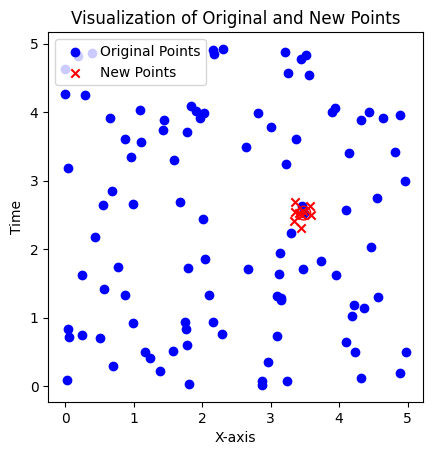

In [3]:
random_flag = True

# Create geometry
geom = geometry.Rectangle(0, 5, 0, 5)
period = time.TimeDomain(0, 1)

points = 100
X = geom.inners(points, random=random_flag).cpu().numpy()
T = period.inners(points, random=random_flag).cpu().numpy()

# Visualization of original points
plt.scatter(X[:, 0], X[:, 1],  label="Original Points", marker='o', color = 'blue')

# Set parameters for rar_points
num_new_points = 9
epsilon = 0.1

# Emulate NN prediction
random_errors = np.random.rand(points)

# Add new points to X
x_new, t_new, (x_center, t_center)  = rar_points(geom, period, X, T, random_errors, num_new_points, epsilon, random_flag)

# Drow a circle
circle = plt.Circle((x_center[0], x_center[1]), epsilon, color='r', fill=False)
ax = plt.gca()
ax.add_artist(circle)

# Make axis equal
ax.set_aspect('equal', adjustable='box')

# Visualization of new points
plt.scatter(x_new[:, 0], x_new[:, 1], label="New Points", marker='x', color='red')
plt.title("Visualization of Original and New Points")
plt.xlabel("X-axis")
plt.ylabel("Time")
plt.legend()
plt.show()